In [180]:
import os
import sys

if os.environ['PY_SOURCES'] not in sys.path:
    sys.path.append(os.environ['PY_SOURCES'])

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%load_ext rpy2.ipython

In [97]:
import numpy as np
import pandas as pd
import kaggle.house_prices.helpers as helpers

combined_dataset = helpers.load_data()

In [186]:
%%R

library(dplyr)
library(ggplot2)

In [3]:
combined_dataset.shape
combined_dataset[combined_dataset['dataSource'] == 'train'].shape
combined_dataset[combined_dataset['dataSource'] == 'test'].shape

(2919, 82)

(1460, 82)

(1459, 82)

In [81]:
colnames = helpers.get_character_colnames(combined_dataset)
colnames.remove('dataSource')
colnames.append('SalePrice')

categ_data = combined_dataset[colnames]
categ_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 45 columns):
Alley            198 non-null object
BldgType         2919 non-null object
BsmtCond         2837 non-null object
BsmtExposure     2837 non-null object
BsmtFinType1     2840 non-null object
BsmtFinType2     2839 non-null object
BsmtQual         2838 non-null object
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2918 non-null object
ExterCond        2919 non-null object
ExterQual        2919 non-null object
Exterior1st      2918 non-null object
Exterior2nd      2918 non-null object
Fence            571 non-null object
FireplaceQu      1499 non-null object
Foundation       2919 non-null object
Functional       2917 non-null object
GarageCond       2760 non-null object
GarageFinish     2760 non-null object
GarageQual       2760 non-null object
GarageType       2762 non-null object
Heating          2919

In [84]:
colnames = helpers.get_numeric_colnames(combined_dataset)
colnames.remove('Id')

numeric_data = combined_dataset[colnames]
numeric_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 36 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
BedroomAbvGr     2919 non-null int64
BsmtFinSF1       2918 non-null float64
BsmtFinSF2       2918 non-null float64
BsmtFullBath     2917 non-null float64
BsmtHalfBath     2917 non-null float64
BsmtUnfSF        2918 non-null float64
EnclosedPorch    2919 non-null int64
Fireplaces       2919 non-null int64
FullBath         2919 non-null int64
GarageArea       2918 non-null float64
GarageCars       2918 non-null float64
GarageYrBlt      2760 non-null float64
GrLivArea        2919 non-null int64
HalfBath         2919 non-null int64
KitchenAbvGr     2919 non-null int64
LotArea          2919 non-null int64
LotFrontage      2433 non-null float64
LowQualFinSF     2919 non-null int64
MasVnrArea       2896 non-null float64
MiscVal          2919 non-null int64
MoSold           2919 

In [114]:
def entropy(col):
    freqs = col.value_counts(dropna=False) / len(col)
    return -np.sum(freqs * np.log2(freqs))

In [139]:
x = (
    categ_data
    .drop('SalePrice', 1)
    .apply(entropy)
    .sort_values()
)
    
x.head(10)
x.tail()

Utilities      0.012627
PoolQC         0.038203
Street         0.038504
Condition2     0.106434
RoofMatl       0.138519
Heating        0.139775
MiscFeature    0.244488
LandSlope      0.303799
CentralAir     0.355183
Alley          0.423391
dtype: float64

BsmtFinType1    2.454724
Exterior1st     2.723429
Exterior2nd     2.800720
MSSubClass      2.920021
Neighborhood    4.212100
dtype: float64

In [138]:
x = (
    numeric_data
    .drop('SalePrice', 1)
    .apply(entropy)
    .sort_values())
    
x.head(10)
x.tail()

PoolArea        0.057677
3SsnPorch       0.158769
LowQualFinSF    0.173265
KitchenAbvGr    0.280959
BsmtHalfBath    0.344808
MiscVal         0.374903
ScreenPorch     0.991907
HalfBath        1.010771
BsmtFullBath    1.077617
FullBath        1.173785
dtype: float64

TotalBsmtSF     9.348757
BsmtUnfSF       9.390885
1stFlrSF        9.601608
GrLivArea       9.882939
LotArea        10.400602
dtype: float64

In [176]:
np.log?

In [179]:
xxx = pd.melt(
    (
        combined_dataset[['SalePrice']]
        .dropna()
        .rename(columns={"SalePrice": "price"})
        .assign(**{'price.log':  lambda df: np.log(df.price)})
    ), 
    var_name='var', 
    value_name='value'
).assign(
    normed_value = lambda df: (
        df.groupby('var', group_keys=False)
          .apply(lambda df: (df.value - np.mean(df.value)) / np.std(df.value))
    )
)

xxx.sort_values(['var', 'value']).groupby('var').tail(5)

,var,value,normed_value
803,price,582933.000000,5.062146
898,price,611657.000000,5.423840
1169,price,625000.000000,5.591855
1182,price,745000.000000,7.102899
691,price,755000.000000,7.228819
2263,price.log,13.275828,3.134810
2358,price.log,13.323927,3.255264
2629,price.log,13.345507,3.309307
2642,price.log,13.521139,3.749141
2151,price.log,13.534473,3.782532


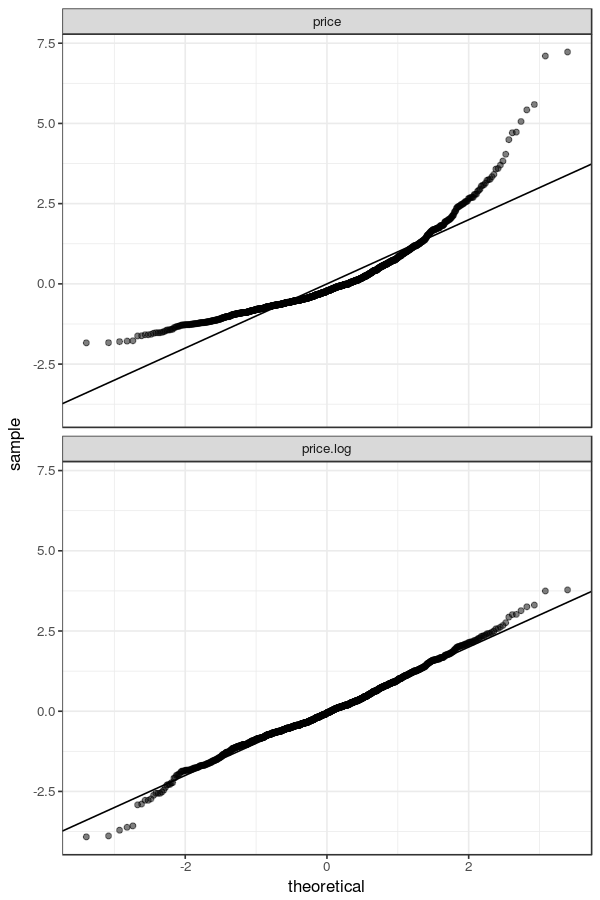

In [203]:
%%R -i xxx -w 600 -h 900 -r 110

xxx %>%
group_by(var) %>%
mutate(
    normed_value = (value - mean(value)) / sd(value)
) %>%
ggplot() +
geom_qq(aes(sample=normed_value), alpha=0.5) +
facet_wrap(~var, ncol=1) +
geom_abline(slope=1) +
theme_bw()